## Check GPU Use:

In [1]:
import tensorflow as tf
print(bool(len(tf.config.list_physical_devices('GPU'))))

True


## Import Libaries:

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Basic libaries:
import os
import random

import pandas as pd
import numpy as np

# Plotting and Image Display libaries:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.segmentation import mark_boundaries

# Neural Network libaries:
import keras
from tensorflow.keras.models import load_model

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

from keras.models import Model
from keras.layers import Input, Flatten, Dense

from keras.optimizers import SGD

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input

from keras.applications import DenseNet201
from keras.applications.densenet import preprocess_input as DenseNet201_preprocess_input

from keras.applications import ResNet152
from keras.applications.densenet import preprocess_input as ResNet152_preprocess_input

# Explanation libaries:
import lime
from lime import lime_image


Using TensorFlow backend.


## Load Data:

In [4]:
# Define data directories:
data_dir_path = "../../data/kaggle/paultimothymooney/chest-xray-pneumonia"

In [5]:
# Load all images from a data directory:
def load_all_images_from_dir(data_dir, target_size):
    
    image_list = []
    for image in os.listdir(data_dir):
        
        image = load_img(os.path.join(data_dir, image), target_size=target_size)
        image_list.append(image)
        
    return image_list



In [6]:
# Combine and transform diffrent image-classes to np-arrays and get class-labels: 
def get_dp_label_pair(class_image_lists, nr_samples = None):

    nr_classes = len(class_image_lists)
    
    # Get "nr_samples" images from each class:
    for i in range(0, nr_classes):
        
        if nr_samples is None:
            class_image_lists[i] = class_image_lists[i]
        else:
            class_image_lists[i] = class_image_lists[i][:nr_samples]
        
    # Get datapoints as np-arrays: 
    datapoints = []
    for j in range(0, nr_classes):    
        for current_dp in class_image_lists[j]:
            
            # Convert current image into a np-arry:
            current_dp = img_to_array(current_dp)
            current_dp = np.expand_dims(current_dp, axis=0)    
            
            datapoints.append(current_dp)
            
    datapoints = np.vstack(datapoints)
    
    # Get the labels from datapoints:
    label_list = []
    for k in range(0, nr_classes):
        
        # Set labels for current class to 1 if first class, else set to zero:
        if k == 0:
            class_labels = np.ones(len(class_image_lists[k]))
        else: 
            class_labels = np.zeros(len(class_image_lists[k]))
            
        for l in range(1, nr_classes):
            
            if l == k:
                class_labels = np.vstack((class_labels, np.ones(len(class_image_lists[l]))))
            else:
                class_labels = np.vstack((class_labels, np.zeros(len(class_image_lists[l]))))
        
        label_list.append(class_labels)
    
    # Reshape label arrays:
    labels = label_list[0].T
    
    for ls in label_list[1:]:
        labels = np.append(labels, ls.T, axis=0)
    
    return datapoints, labels
    


In [7]:
# Get list of image from "normal chest xray" data directory:
normal_data_dir = os.path.join(data_dir_path, "test", "NORMAL")
normal_image_list_full = load_all_images_from_dir(normal_data_dir, (224, 224))

# Get list of image from "pneumonia chest xray" data directory:
pneumonia_data_dir = os.path.join(data_dir_path, "test", "PNEUMONIA")
pneumonia_image_list_full = load_all_images_from_dir(pneumonia_data_dir, (224, 224))

# Combine list of diffrent class images into a single list:
normal_pneumonia_lists_full = [normal_image_list_full, pneumonia_image_list_full]

# Get datapoints and labels from images:
nr_samples = 200
x_data, y_data = get_dp_label_pair(normal_pneumonia_lists_full, nr_samples = nr_samples) 


## Get and Retrain Model:

In [8]:
# Load pretrained Keras CNNs without the fully connected layer weights (trained on imagenet-data):
VGG16_model_wo_top = VGG16(weights='imagenet', include_top=False)
ResNet152_model_wo_top = ResNet152(weights='imagenet', include_top=False)
DenseNet201_model_wo_top = DenseNet201(weights='imagenet', include_top=False)


In [9]:
def redefine_model_wo_top(model, input_shape = (224,224,3), nr_classes = 2, fc_layer_structure = [2048, 2048]):

    # Define the new input format for the given model (e.g. 3 channels - 224 width x 224 height):
    model_input = Input(shape=input_shape, name = 'model_input')
    
    # Reuse convolutional layer of the given model: 
    model_output = model(model_input)

    # Define new fully connected layer structure:
    x = Flatten(name='flatten')(model_output)
    
    for i, fc_layer_neurons in enumerate(fc_layer_structure): 
        x = Dense(fc_layer_neurons, activation='relu', name='fc' + str(i))(x)
    
    x = Dense(nr_classes, activation='softmax', name='predictions')(x)

    #Create your own model 
    new_model = Model(input = model_input, output = x)

    return new_model


In [10]:
# Train model for binary classification (loss = categorical_crossentropy):
def train_model(model, x_train, y_train, x_test = None, y_test = None, batch_size = 1, epochs = 10, shuffle = True, optimizer = SGD(lr = 0.0001, decay = 1e-6, momentum = 0.01, nesterov = True)):
    
    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = shuffle)
    
    score = []
    if not (x_test is None):
        score = model.evaluate(x_test, y_test, batch_size = batch_size)        
        
    return model, score


In [11]:
# Model structure parameters:
nr_classes = 2
input_shape = (224,224,3)
fc_layer_structure = [2048, 2048]

# Training parameters:
shuffle = True
batch_size = 1
epochs = 5


In [12]:
vgg16_model = redefine_model_wo_top(model = VGG16_model_wo_top, input_shape = input_shape, nr_classes = nr_classes, fc_layer_structure = fc_layer_structure)
vgg16_model, score = train_model(vgg16_model, x_data, y_data, batch_size = batch_size, epochs = epochs, shuffle = shuffle)


Epoch 1/5
400/400 [==============================] - 46s 114ms/step - loss: 0.5842 - accuracy: 0.8125
Epoch 2/5
400/400 [==============================] - 9s 22ms/step - loss: 0.1699 - accuracy: 0.9375
Epoch 3/5
400/400 [==============================] - 9s 23ms/step - loss: 0.0928 - accuracy: 0.9700
Epoch 4/5
400/400 [==============================] - 9s 23ms/step - loss: 0.0759 - accuracy: 0.9775
Epoch 5/5
400/400 [==============================] - 9s 23ms/step - loss: 0.0216 - accuracy: 0.9950


In [13]:
resnet152_model = redefine_model_wo_top(model = ResNet152_model_wo_top, input_shape = input_shape, nr_classes = nr_classes, fc_layer_structure = fc_layer_structure)
resnet152_model, score = train_model(resnet152_model, x_data, y_data, batch_size = batch_size, epochs = epochs, shuffle = shuffle)


Epoch 1/5
400/400 [==============================] - 166s 415ms/step - loss: 0.3640 - accuracy: 0.8225
Epoch 2/5
400/400 [==============================] - 50s 125ms/step - loss: 0.0963 - accuracy: 0.9650
Epoch 3/5
400/400 [==============================] - 50s 126ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 4/5
400/400 [==============================] - 51s 128ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 5/5
400/400 [==============================] - 51s 128ms/step - loss: 0.0030 - accuracy: 1.0000


In [28]:
densenet201_model = redefine_model_wo_top(model = DenseNet201_model_wo_top, input_shape = input_shape, nr_classes = nr_classes, fc_layer_structure = fc_layer_structure)
densenet201_model, score = train_model(densenet201_model, x_data, y_data, batch_size = batch_size, epochs = epochs, shuffle = shuffle)


Epoch 1/5
400/400 [==============================] - 104s 261ms/step - loss: 0.2938 - accuracy: 0.8825
Epoch 2/5
400/400 [==============================] - 56s 139ms/step - loss: 0.0160 - accuracy: 1.0000
Epoch 3/5
400/400 [==============================] - 56s 139ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 4/5
400/400 [==============================] - 56s 139ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 5/5
400/400 [==============================] - 56s 139ms/step - loss: 0.0034 - accuracy: 1.0000


## Predict Data:

In [29]:
def prepare_images_for_model(loaded_images, preprocess_input_function = None):

    images = []
    for image in loaded_images:
    
        # Convert the image into a np-array:
        image = img_to_array(image)

        # Reshape the image array (add first dimension for the batchsize):
        image = np.expand_dims(image, axis=0) 

        # Preprocess the image for the VGG16-model:
        if preprocess_input_function is None:
            pass
        else:
            image = preprocess_input_function(image)
        
        images.append(image)
    
    images = np.vstack(images)
    return images



In [30]:
def predict_xray_image(model, image, label_list = ["Normal", "Pneumonia"], display_results = False, return_prob = False):
    
    prepared_image = prepare_images_for_model([image], preprocess_input_function = None)

    # Predict class-propabilities for loaded images using the new model:
    new_model_predictions_prob = list(model.predict(prepared_image)[0])
    predict_model_label = label_list[new_model_predictions_prob.index(max(new_model_predictions_prob))]
    
    if display_results:
        
        # Display loaded single image:
        imgplot_xray = plt.imshow(image)
        plt.show()

        # Display top class propabilities from single loaded image: 
        print("Label:", predict_model_label, "\n")        
    
    if return_prob:
        return predict_model_label, new_model_predictions_prob
    else:
        return predict_model_label
    
    

Predict "normal" and "pneumonia" image with retrained Keras-Models:

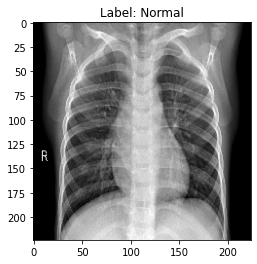

Predictions:

VGG16: Normal
ResNet152: Normal
DenseNet201: Normal


In [31]:
normal_test_image = random.choice(normal_image_list_full)

vgg16_prediction = predict_xray_image(vgg16_model, normal_test_image, label_list = ["Normal", "Pneumonia"], display_results = False)
resnet152_prediction = predict_xray_image(resnet152_model, normal_test_image, label_list = ["Normal", "Pneumonia"], display_results = False)
densenet201_prediction = predict_xray_image(densenet201_model, normal_test_image, label_list = ["Normal", "Pneumonia"], display_results = False)

imgplot_xray = plt.imshow(normal_test_image)
plt.title("Label: Normal")
plt.show()

print("Predictions:\n")
print("VGG16:", vgg16_prediction)
print("ResNet152:", resnet152_prediction)
print("DenseNet201:", densenet201_prediction)

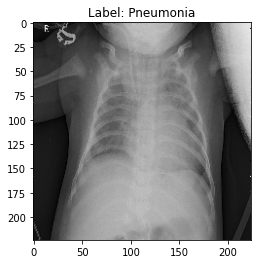

Predictions:

VGG16: Pneumonia
ResNet152: Pneumonia
DenseNet201: Pneumonia


In [32]:
pneumonia_test_image = random.choice(pneumonia_image_list_full)

vgg16_prediction = predict_xray_image(vgg16_model, pneumonia_test_image, label_list = ["Normal", "Pneumonia"], display_results = False)
resnet152_prediction = predict_xray_image(resnet152_model, pneumonia_test_image, label_list = ["Normal", "Pneumonia"], display_results = False)
densenet201_prediction = predict_xray_image(densenet201_model, pneumonia_test_image, label_list = ["Normal", "Pneumonia"], display_results = False)

imgplot_xray = plt.imshow(pneumonia_test_image)
plt.title("Label: Pneumonia")
plt.show()

print("Predictions:\n")
print("VGG16:", vgg16_prediction)
print("ResNet152:", resnet152_prediction)
print("DenseNet201:", densenet201_prediction)


## Use LIME to explain predictions:

In [33]:
# Define LIME-Explainer Instance:
explainer = lime_image.LimeImageExplainer()


In [34]:
def explain_predictions(model, x_dataset, nr_samples = None, indecies = None, classes = ["Normal", "Pneumonia"], num_samples_lime = 1000, num_features_lime = 10, figwidth = 10, figheight = 10):

    if (nr_samples is None) and (indecies is None):
        return -1
    
    # Get number of classes:
    nr_classes = len(classes)
    
    # If no indecies are given, select "nr_samples" samples:
    if indecies is None:
        indecies = random.sample(range(x_data.shape[0]), nr_samples)
    else:
        nr_samples = len(indecies)
    
    # Set plot height and width:
    fig, ax = plt.subplots(nr_samples, nr_classes + 1, sharex='col', sharey='row')
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
                
    xs = [np.array(prepare_images_for_model([x]), dtype=np.uint8)[0] for x in x_dataset]

    # Get explanations for all selected images:
    for j in range(nr_samples):
        explanation = explainer.explain_instance(xs[indecies[j]], model.predict, 
                                                 top_labels=nr_classes, hide_color=0, num_samples=num_samples_lime)

        ax[j,0].imshow(xs[indecies[j]])
        ax[j,0].set_title(classes[list(y_data[indecies[j]]).index(max(list(y_data[indecies[j]])))])

        xs_pred_label, xs_pred_prob = predict_xray_image(model, xs[indecies[j]], label_list = classes, 
                                                         display_results = False, return_prob = True)
        
        for i in range(nr_classes):
            temp, mask = explanation.get_image_and_mask(i, positive_only=False, 
                                                        num_features=num_features_lime, hide_rest=False)

            temp = np.array(temp, dtype=np.uint8)

            ax[j,i+1].imshow(mark_boundaries(temp, mask))
            ax[j,i+1].set_title('p({}) = {:.4f}'.format(classes[i], xs_pred_prob[i]))
            
            
    return fig, ax
    


In [35]:
# Set specific indecies:
indecies = [50, 250]


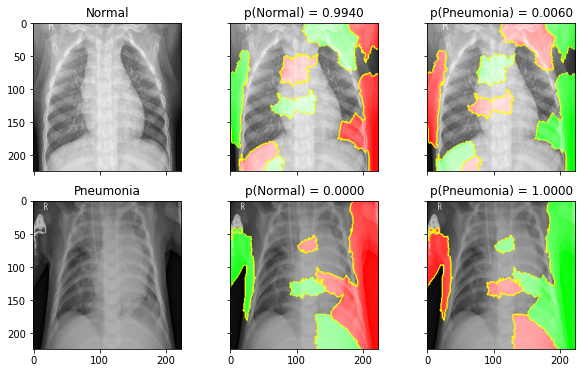

In [36]:
# Get Explanations for VGG16-Model:
fig, ax = explain_predictions(vgg16_model, x_data, indecies = indecies, classes = ["Normal", "Pneumonia"], num_features_lime = 10, num_samples_lime = 10000, figheight = 6)


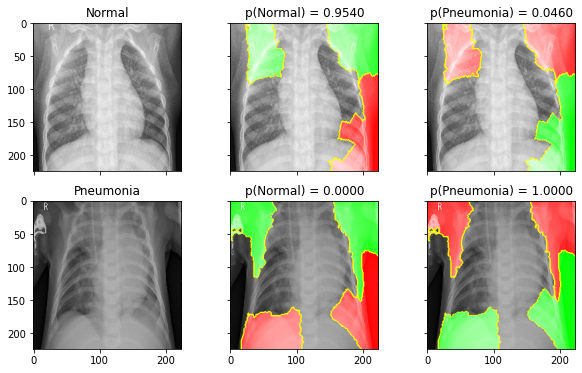

In [37]:
# Get Explanations for ResNet152-Model:
fig, ax = explain_predictions(resnet152_model, x_data, indecies = indecies, classes = ["Normal", "Pneumonia"], num_features_lime = 10, num_samples_lime = 10000, figheight = 6)


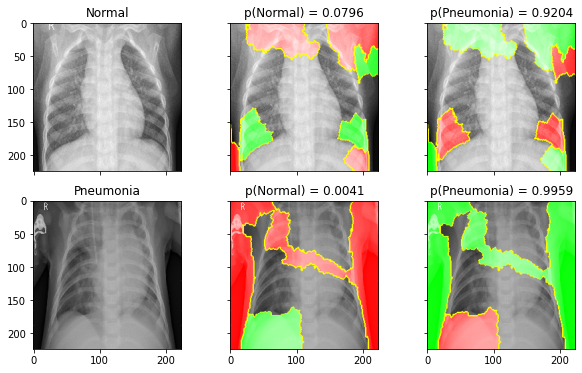

In [38]:
# Get Explanations for DenseNet201-Model:
fig, ax = explain_predictions(densenet201_model, x_data, indecies = indecies, classes = ["Normal", "Pneumonia"], num_features_lime = 10, num_samples_lime = 10000, figheight = 6)


## Save and Load Models:

In [39]:
model_dir = "../results/models"


In [44]:
def save_model(model, model_name):
    model.save(model_dir + '/' + model_name)  # creates a HDF5 file 'my_model.h5'

def load_model(model_name):
    # Returns a compiled model:
    model = load_model(model_dir + '/' + model_name)
    return model


In [45]:
# Save Keras-Models:
save_model(vgg16_model, "vgg16_model.h5")
save_model(resnet152_model, "resnet152_model.h5")
save_model(densenet201_model, "densenet201_model.h5")